**If possible, Please run this file in google colab**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

**Loading Cosmic Chronometer (CC) data points: redshifts, H(z) values and statistical errors**

In [ ]:
# Data taken from https://github.com/Ahmadmehrabi/Cosmic_chronometer_data.
# The data file is also available in the course repository

data_cc = np.loadtxt('/content/HzTable_MM_BC32.txt')

In [ ]:
z = data_cc[:,0]   # redhifts
Hz = data_cc[:,1]  # H(z) values
errHz = data_cc[:,2]  # statistical errors

In [ ]:
z

array([0.07  , 0.09  , 0.12  , 0.17  , 0.179 , 0.199 , 0.2   , 0.27  ,
       0.28  , 0.352 , 0.38  , 0.4   , 0.4004, 0.425 , 0.445 , 0.47  ,
       0.4783, 0.48  , 0.593 , 0.68  , 0.75  , 0.781 , 0.875 , 0.88  ,
       0.9   , 1.037 , 1.3   , 1.363 , 1.43  , 1.53  , 1.75  , 1.965 ])

In [ ]:
errHz

array([19.6, 12. , 26.2,  8. ,  4. ,  5. , 29.6, 14. , 36.6, 14. , 13.5,
       17. , 10.2, 11.2, 12.9, 49.6,  9. , 62. , 13. ,  8. , 33.6, 12. ,
       17. , 40. , 23. , 20. , 17. , 33.6, 18. , 14. , 40. , 50.4])

**Plotting the data**

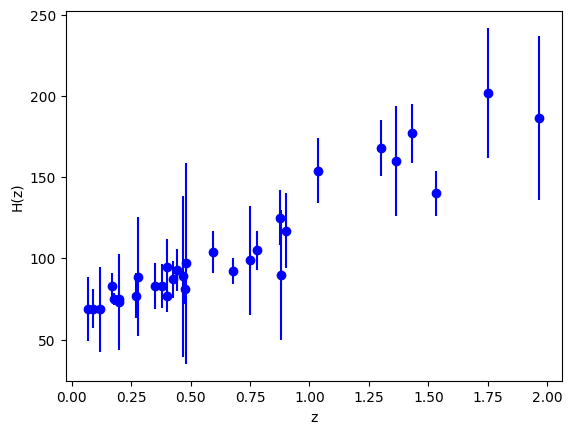

In [ ]:
plt.errorbar(z, Hz, yerr=errHz, fmt='o', label='data', color = 'blue')
plt.xlabel('z')
plt.ylabel('H(z)')
plt.show()

**Loading the data for covariance matrix estimation**

In [ ]:
# Data for this part and also the method for calculating the full covariance matrix (next two block) are available here:
# https://gitlab.com/mmoresco/CCcovariance/-/blob/master/examples/CC_fit.ipynb
# The data file is also available in the course repository.

filename = 'data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

**Estimating CC Covariance components**

In [ ]:
cov_mat_diag = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	cov_mat_diag[i,i] = errHz[i]**2

imf_intp = np.interp(z, zmod, imf)/100
slib_intp = np.interp(z, zmod, slib)/100
sps_intp = np.interp(z, zmod, sps)/100
spsooo_intp = np.interp(z, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_slib = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_sps = np.zeros((len(z), len(z)), dtype='float64')
cov_mat_spsooo = np.zeros((len(z), len(z)), dtype='float64')

for i in range(len(z)):
	for j in range(len(z)):
		cov_mat_imf[i,j] = Hz[i] * imf_intp[i] * Hz[j] * imf_intp[j]
		cov_mat_slib[i,j] = Hz[i] * slib_intp[i] * Hz[j] * slib_intp[j]
		cov_mat_sps[i,j] = Hz[i] * sps_intp[i] * Hz[j] * sps_intp[j]
		cov_mat_spsooo[i,j] = Hz[i] * spsooo_intp[i] * Hz[j] * spsooo_intp[j]

**Estimated full covariance matrix and its inverse**

In [ ]:
cov_mat = cov_mat_spsooo+cov_mat_imf+cov_mat_diag
Cov_inv = np.linalg.inv(cov_mat)

**Defining our model for H(z). Assuming a $\Lambda$CDM cosmology with flat spatial geometry and negligible radiation, we have: $H(z) = H_{0} \sqrt{\Omega_{m}(1 + z)^{3} + 1 - \Omega_{m}}$**:

In [ ]:
def H_model(z, H0, Om):
    return H0 * np.sqrt(Om * (1.0 + z)**3 + 1.0 - Om)

In [ ]:
from scipy.optimize import minimize

**Defing the corresponding $\chi^2$**

In [ ]:
def chi2(H0, Om):
    H_th = H_model(z, H0, Om)
    dH = H_th - Hz
    return dH @ Cov_inv @ dH

In [ ]:
def chi2_wrapper(params):
    H0, Om = params
    return chi2(H0, Om)

**Minimizing $\chi^2$ to find the best fit parameters**

In [ ]:
res = minimize(chi2_wrapper, x0=[70,0.3], method='Nelder-Mead')  # x0 is an initial guess

In [ ]:
H0_best, Om_best = res.x
chi2_min = res.fun

In [ ]:
print(H0_best, Om_best, chi2_min)

67.60082495621484 0.3226191502582074 14.538251755632572


**Quick goodness-of-fit estimate: $\chi^2/\nu$**

In [ ]:
print(chi2_min / (len(Hz) - 2))   # number of data points = len(Hz), number of parameters = 2

0.48460839185441906


**Defining a grid of $H_{0}$ and $\Omega_{m}$ values to obtain Confidence regions**

In [ ]:
# Define parameter ranges
H0_grid = np.linspace(45, 90, 400)
Om_grid = np.linspace(0.1, 0.65, 400)

# Initialize chi2 grid
chi2_grid = np.zeros((len(H0_grid), len(Om_grid)))

# Fill the grid
for i, H0 in enumerate(H0_grid):
    for j, Om in enumerate(Om_grid):
        chi2_grid[i, j] = chi2(H0, Om)

**Contour levels for 1$\sigma$ and 2$\sigma$ regions**

In [ ]:
levels = [chi2_min + 2.30, chi2_min + 6.18]
H0_mesh, Om_mesh = np.meshgrid(H0_grid, Om_grid, indexing='ij')

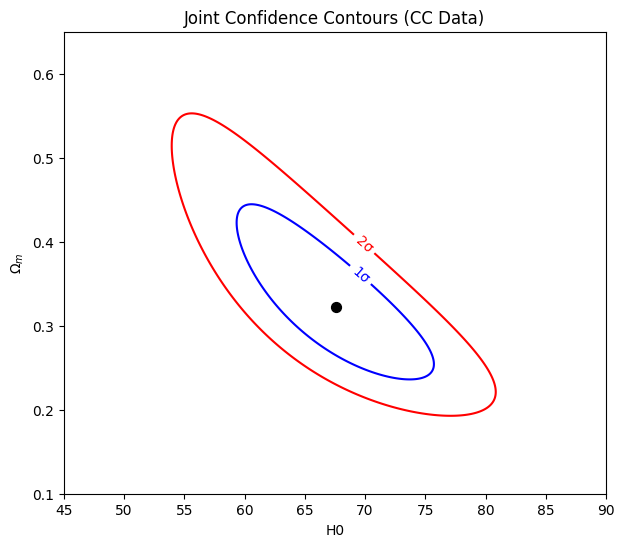

In [ ]:
plt.figure(figsize=(7, 6))
cs = plt.contour(H0_mesh, Om_mesh, chi2_grid,
                 levels=levels, colors=['blue','red'])
plt.clabel(cs, inline=True, fmt={levels[0]:'1σ', levels[1]:'2σ'})
plt.scatter(H0_best, Om_best, color='k', marker='o', s=50)
plt.xlabel('H0')
plt.ylabel('$\\Omega_m$')
plt.title('Joint Confidence Contours (CC Data)')
plt.show()

**We can also obtain the 1D confidence intervals for each parameter**

In [ ]:
chi2_profile_H0 = chi2_grid.min(axis=1)      # minimize over Om
chi2_profile_Om = chi2_grid.min(axis=0)      # minimize over H0

In [ ]:
def confidence_interval(x_grid, chi2_profile, chi2_min, delta):
    mask = chi2_profile <= chi2_min + delta
    return x_grid[mask].min(), x_grid[mask].max()

# We should use the level parameters for 1 parameter not 2.

for delta, label in [(1,'1σ'), (4,'2σ')]:
    print(f"{label} H0:", confidence_interval(H0_grid, chi2_profile_H0, chi2_min, delta))
    print(f"{label} Om:", confidence_interval(Om_grid, chi2_profile_Om, chi2_min, delta))

1σ H0: (np.float64(62.255639097744364), np.float64(72.85714285714286))
1σ Om: (np.float64(0.26265664160401003), np.float64(0.3977443609022556))
2σ H0: (np.float64(56.72932330827068), np.float64(78.27067669172932))
2σ Om: (np.float64(0.21441102756892233), np.float64(0.49423558897243114))


**Bayesian Inference: Finding Posteriors via MCMC**

In [ ]:
!pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install corner

In [ ]:
import os
from scipy.integrate import quad
import emcee
import corner
import time

**Defining logarithm of likelihood and prior**

In [ ]:
def log_likelihood(theta):
    H0, Om = theta
    return -0.5 * chi2(H0, Om)

In [ ]:
# Here we define a uniform prior but one can modify it to any other types of priors like Gaussian, etc.
def log_prior(theta):
    H0, Om = theta
    if 40 < H0 < 100 and 0.0 < Om < 1.0:
        return 0.0  # flat prior → log(1)
    return -np.inf

**Here we define posterior based on previous two definitions**

In [ ]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

**Initializing MCMC sampler**

In [ ]:
# Parameters can be chosen differently for better accuracy, etc.

ndim = 2
nwalkers = 64
# initial guess near a typical best-fit; use small scatter around it
initial = np.array([70.0, 0.3])
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

In [ ]:
nsteps_burn = 10000
nsteps_prod = 40000

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

In [ ]:
state = sampler.run_mcmc(p0, 2000, progress=True)
sampler.reset()

100%|██████████| 2000/2000 [00:05<00:00, 383.31it/s]


**Running MCMC and obtaining samples**

In [ ]:
sampler.run_mcmc(state, 5000, progress=True);

100%|██████████| 5000/5000 [00:15<00:00, 319.69it/s]


**Here we obtain the joint posterior distribution**

In [ ]:
samples = sampler.get_chain(flat=True)
print(samples.shape)

(320000, 2)


**Here are marginalized posteriors for each parameter.**

In [ ]:
H0_samples = samples[:,0]
Om_samples = samples[:,1]

**What MCMC actually produces**

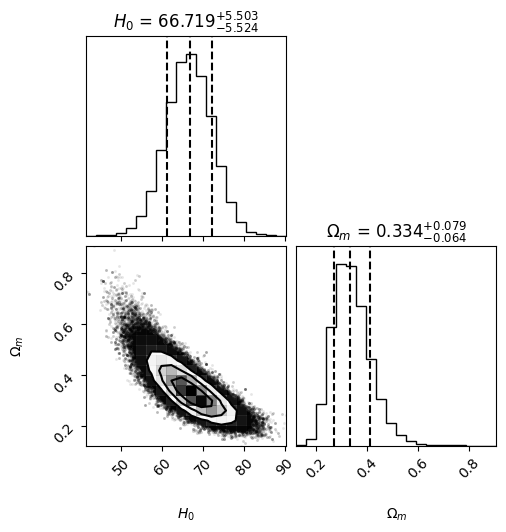

In [ ]:
import corner

figure = corner.corner(
    samples,
    labels=[r"$H_0$", r"$\Omega_m$"],
    show_titles=True,
    quantiles=[0.1585, 0.5, 0.8415],  # These numbers are related to 1-sigma (68.3%) CL that are specified by dash lines. We will also separately calculate them later.
    title_fmt=".3f"
)

In [ ]:
!pip install getdist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.0/834.0 kB 46.3 MB/s eta 0:00:00


**Smoothing the data (shown in previous plot): Bottom plot: The joint $1 \sigma$ and $2 \sigma$ contours, Right plot: Posterior distribution for $\Omega_{m}$, Top plot: Posterior distribution for $H_{0}$**

Removed no burn in


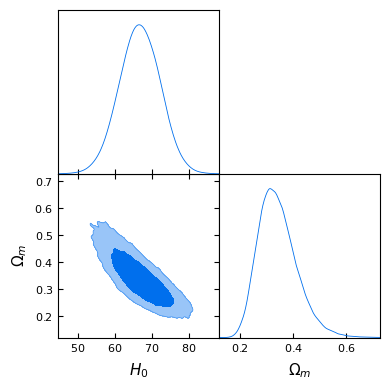

In [ ]:
from getdist import MCSamples, plots
import numpy as np

mc = MCSamples(samples=samples, names=["H0","Om"], labels=[r"H_0", r"\Omega_m"])

# For more options/modifications on the plots, please see the getdist directory online

g = plots.get_subplot_plotter()

g.triangle_plot(mc, filled=True)

**We can also find the credible intervals. Here, as an example, we find them for $1 \sigma \, (68.3\%)$ CL**

In [ ]:
# One common choice for the "best fit" value from a given posterior is the median.

def credible_interval(arr, level):
    lo = (1.0 - level)/2.0
    hi = 1.0 - lo
    qlo, qmed, qhi = np.quantile(arr, [lo, 0.5, hi])
    return qmed, qmed - qlo, qhi - qmed

In [ ]:
h0_med68, h0_minus68, h0_plus68 = credible_interval(H0_samples, level=0.683)
Om_med68, Om_minus68, Om_plus68 = credible_interval(Om_samples, level=0.683)

In [ ]:
print(f"H0: median = {h0_med68:.3f}, -1σ = {h0_minus68:.3f}, +1σ = {h0_plus68:.3f}, 68.3% CI = [{h0_med68 - h0_minus68:.3f}, {h0_med68 + h0_plus68:.3f}]")
print(f"Om: median = {Om_med68:.3f}, -1σ = {Om_minus68:.3f}, +1σ = {Om_plus68:.3f}, 68.3% CI = [{Om_med68 - Om_minus68:.3f}, {Om_med68 + Om_plus68:.3f}]")

H0: median = 66.719, -1σ = 5.524, +1σ = 5.503, 68.3% CI = [61.195, 72.222]
Om: median = 0.334, -1σ = 0.064, +1σ = 0.079, 68.3% CI = [0.271, 0.414]


**If needs be, one can also find the parameters that maximize the posterior probability**

In [ ]:
# samples from emcee
samples = sampler.get_chain(flat=True)  # shape (n_samples, n_params)

# we pick the sample with the highest posterior probability

logpost = sampler.get_log_prob(flat=True)  # shape (n_samples,)
max_idx = np.argmax(logpost)
MAP_sample = samples[max_idx]

print("MAP estimate:", MAP_sample)

MAP estimate: [67.59814666  0.32282473]


**Model Comparison: Here we fix values of $H_0$ and $\Omega_{m}$ and focus on dark energy parameters.**

In [ ]:
H0_fixed = 70.0
Om_fixed = 0.3

**We compare two models of dark energy. For model 1 we assume that dark energy EoS parameter, $w$, is constant. Therefore the Hubble parameter becomes (assuming a flat universe and negligible radiation): $H(z) = H_{0} \sqrt{\Omega_{m}(1 + z)^{3} + (1 - \Omega_{m})(1+z)^{3(1 + w)}}$. For model 2, we asssume that $w$ changes with scale factor: $w = w(a) = w_{0} + w_{a}(1 - a)$ (CPL parametrization). The redshift, $z$, and the scale factor, $a$, are related via $1 + z = 1/a$. For model 2, the Hubble parameter is: $H(z) = H_{0} \sqrt{\Omega_{m}(1 + z)^{3} + (1 - \Omega_{m})(1+z)^{3(1 + w_0 + w_a)}e^{-3 w_a \frac{z}{1+z}}}$**

In [ ]:
# model 1

def H_w_constant(z, H0, Om, w):
    return H0 * np.sqrt(Om*(1+z)**3 + (1-Om)*(1+z)**(3*(1+w)))

In [ ]:
# model 2

def H_CPL(z, H0, Om, w0, wa):
    DE_factor = (1 + z)**(3*(1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    return H0 * np.sqrt(Om*(1+z)**3 + (1-Om)*DE_factor)

**$\chi^2$ and log likelihood definitions**

In [ ]:
def chi2_from_model(H_model_vals, H_data, Cov_inv):
    dH = H_model_vals - Hz
    return float(dH @ Cov_inv @ dH)

In [ ]:
def loglike_const_w(theta):
    # theta = [w]
    w = theta[0]
    Hm = H_w_constant(z, H0_fixed, Om_fixed, w)
    chi2 = chi2_from_model(Hm, Hz, Cov_inv)
    return -0.5 * chi2

In [ ]:
def loglike_cpl(theta):
    # theta = [w0, wa]
    w0, wa = theta
    Hm = H_CPL(z, H0_fixed, Om_fixed, w0, wa)
    chi2 = chi2_from_model(Hm, Hz, Cov_inv)
    return -0.5 * chi2

**To find the Bayes factor, we need to integrate the product of likelihood and prior distributions over model parameters for each model. This can be done by just sampling the product and integrating it numerically. We can do it manually or use nested sampling packages (much faster).**

In [ ]:
!pip install dynesty

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 7.3 MB/s eta 0:00:00


In [ ]:
from dynesty import NestedSampler
import dynesty

**Specifying priors (transformed from unit intervals/cubes) for each model**

In [ ]:
# Prior transforms (unit cube u in [0,1] -> parameter space)
# We Choose priors and state them explicitly
# Example priors (one can choose different priors):

# constant-w: w ~ Uniform(w_min, w_max)

w_min, w_max = -2.0, -0.3

# CPL: w0 ~ Uniform(w0_min,w0_max), wa ~ Uniform(wa_min, wa_max)
w0_min, w0_max = -2.0, -0.3
wa_min, wa_max = -2.0,  2.0

def prior_transform_const_w(u):
    w = w_min + u[0] * (w_max - w_min)
    return np.array([w])

def prior_transform_cpl(u):
    # u is array-like of shape (2,)
    w0 = w0_min + u[0] * (w0_max - w0_min)
    wa = wa_min + u[1] * (wa_max - wa_min)
    return np.array([w0, wa])

**Nested sampling for each model**

In [ ]:
ndim1 = 1
sampler1 = NestedSampler(loglike_const_w, prior_transform_const_w, ndim1, nlive=5000)
sampler1.run_nested(dlogz=0.1)   # choose dlogz according to desired evidence precision
res1 = sampler1.results

16027it [00:15, 1055.02it/s, +5000 | bound: 0 | nc: 1 | ncall: 129207 | eff(%): 16.929 | loglstar:   -inf < -7.312 <    inf | logz: -8.166 +/-  0.001 | dlogz:  0.000 >  0.100]


In [ ]:
ndim2 = 2
sampler2 = NestedSampler(loglike_cpl, prior_transform_cpl, ndim2, nlive=5000)
sampler2.run_nested(dlogz=0.1)
res2 = sampler2.results

17586it [00:16, 1053.97it/s, +5000 | bound: 0 | nc: 1 | ncall: 174934 | eff(%): 13.291 | loglstar:   -inf < -7.163 <    inf | logz: -8.332 +/-  0.007 | dlogz:  0.000 >  0.100]


In [ ]:
logZ1 = res1.logz[-1]
logZerr1 = res1.logzerr[-1]
logZ2 = res2.logz[-1]
logZerr2 = res2.logzerr[-1]

print(f"Model 1: logZ = {logZ1:.5f} ± {logZerr1:.5f}")
print(f"Model 2: logZ = {logZ2:.5f} ± {logZerr2:.5f}")

Model 1: logZ = -8.16555 ± 0.01415
Model 2: logZ = -8.33165 ± 0.01601


**Finding the Bayes ratio**

In [ ]:
logB = logZ1 - logZ2
B = np.exp(logB)
# propagate error approximately: sigma_logB = sqrt(err1^2 + err2^2)
sigma_logB = np.sqrt(logZerr1**2 + logZerr2**2)

In [ ]:
print(f"log Bayes factor (log Z1 - log Z1) = {logB:.3f} ± {sigma_logB:.3f}")
print(f"Bayes factor B(model1/model2) = {B:.3f}  (model 1 is favored if >1)")

log Bayes factor (log Z1 - log Z1) = 0.166 ± 0.021
Bayes factor B(model1/model2) = 1.181  (model 1 is favored if >1)


**Previous result shows that constant dark energy EoS is slightly favored over the CPL model. Below we perform two other tests**

**Model Comparison via AIC and BIC**

In [ ]:
def chi2_const_w(theta):
    # theta = [w]
    w = theta[0]
    Hm = H_w_constant(z, H0_fixed, Om_fixed, w)
    chi2 = chi2_from_model(Hm, Hz, Cov_inv)
    return chi2

In [ ]:
res_const_w = minimize(chi2_const_w, x0=[-1], method='Nelder-Mead')

In [ ]:
wbest = res_const_w.x
chi2_const_w_min = res_const_w.fun

In [ ]:
print(wbest, chi2_const_w_min)

[-1.08271484] 14.62486418509434


In [ ]:
print(f"AIC = {chi2_const_w_min + 2} and BIC = {chi2_const_w_min + np.log(len(Hz))}")

AIC = 16.62486418509434 and BIC = 18.090600087894067


In [ ]:
def chi2_cpl(theta):
    # theta = [w0, wa]
    w0, wa = theta
    Hm = H_CPL(z, H0_fixed, Om_fixed, w0, wa)
    chi2 = chi2_from_model(Hm, Hz, Cov_inv)
    return  chi2

In [ ]:
res_cpl = minimize(chi2_cpl, x0=[-1, 0], method='Nelder-Mead')

In [ ]:
w0_best, wa_best = res_cpl.x
chi2_cpl = res_cpl.fun

In [ ]:
print(w0_best, wa_best, chi2_cpl)

-1.3066658932052633 0.8954772517099208 14.326408480048679


In [ ]:
print(f"AIC = {chi2_cpl + 4} and BIC = {chi2_const_w_min + 2*np.log(len(Hz))}")

AIC = 18.326408480048677 and BIC = 21.556335990693793


**Model 1 (Constant w) has lower values of both AIC and BIC and therefore is favored**